# Ajuste de modelo SEIR

Ajuste de un modelo SEIR discreto de paso diario a casos observados, y proyección de casos futuros.



### Bibliotecas 

Bibliotecas de código que se van a utilizar

In [ ]:
# bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
!pip install wget
import wget
import os

## Variables de entrada

### Municipio

In [ ]:
municipio = 'Lobería'

In [ ]:
# listado de municipios de la región sanitaria VIII, y la población de cada uno
municipios = ['Ayacucho', 'Balcarce', 'General Alvarado', 'General Guido', 'General Juan Madariaga', 'General Lavalle', 'General Pueyrredón', 'La Costa', 'Lobería', 'Maipú', 'Mar Chiquita', 'Necochea', 'Pinamar', 'San Cayetano', 'Tandil', 'Villa Gesell']
poblaciones = [21291, 45691, 44149, 2892, 21596, 4459, 656456, 78554, 18281, 10388, 25344, 95995, 31584, 8797, 139300, 38034]
datos_municipios = pd.DataFrame(poblaciones, index=municipios, columns=['poblacion'])
# buscar el dato de población del municipio seleccionado
poblacion = datos_municipios.loc[municipio, 'poblacion']

print('Municipio:', municipio)
print('Población:', poblacion)

datos_municipios

Municipio: Lobería
Población: 18281


,poblacion
Ayacucho,21291
Balcarce,45691
General Alvarado,44149
General Guido,2892
General Juan Madariaga,21596
General Lavalle,4459
General Pueyrredón,656456
La Costa,78554
Lobería,18281
Maipú,10388


### Parámetros

Valores para los parámetros del modelo y otras variables necesarias para las simulaciones: 

- El valor del parámetro R0 es el que se va a ajustar a los datos, por lo que el valor que se indica acá se toma sólo como valor inicial. Los parámetros alpha y gamma son fijos, y el parámetro beta se calcula a partir de R0 y gamma.

- Los parámetros se ajustan para 3 períodos de tiempo de distinta duración, tomando los datos de, por ejemplo, las últimas 1, 2 y 3 semanas. Para asegurar un mejor ajuste, en cada caso se inician las simulaciones unos días antes ('lag') del período a considerar.

- Luego para cada ajuste de parámetros, se realiza una proyección hacia el futuro, una cierta cantidad de días.

In [ ]:
# parámetros del modelo SEIR
R0 = 1.5
alpha = 1 / 3
gamma = 1 / 7
beta = R0 * gamma
# población total
T = poblacion

# días que se consideran para realizar el ajuste de parámetros
duracion_ajuste_1 = 21
duracion_ajuste_2 = 14
duracion_ajuste_3 =  7

# cuántos días antes se inicia la simulación para que se 'estabilicen' los valores
duracion_lag = 7

# duración de la proyección
duracion_proyeccion = 15

# columna de datos a ajustar
columna_datos = 'Estimado'

### Otras configuraciones

Configuraciones de estilo de los gráficos

In [ ]:
# estilo para los gráficos
plt.style.use('seaborn-whitegrid')
plt.rcParams['lines.linewidth'] = 4
plt.rcParams["legend.loc"] = 'best'
plt.rcParams["xtick.labelsize"] = 11
plt.rcParams["ytick.labelsize"] = 11
plt.rcParams["axes.labelsize"] = 8


## Datos

Descargar los datos del SISA, procesarlos y graficarlos.

### Descargar datos

Los datos a utilizar se toman del archivo csv de datos abiertos del Ministerio de Salud, con datos del SISA con fecha de corte diaria a las 17:45. 

In [ ]:
# dirección web de la que se descargan los datos
url_datos_sisa = 'https://sisa.msal.gov.ar/datos/descargas/covid-19/files/Covid19Casos.csv'

# archivo donde se guardan
archivo_datos_sisa = 'Covid19Casos.csv'

# descargar datos
# si el archivo no existe, descargarlo
if not os.path.exists(archivo_datos_sisa):
  wget.download(url_datos_sisa, archivo_datos_sisa)
else:
  print('Base de datos SISA ya descargada')

Base de datos SISA ya descargada


### Leer datos

Leer el archivo de datos e incorporarlos a una tabla

In [ ]:
# datos de entrada
# fuente de datos Ministerio de Salud: http://datos.salud.gob.ar/dataset/covid-19-casos-registrados-en-la-republica-argentina
# chequear columnas con fechas, separador (, o ;), encoding (utf-8 o 16)
columnas_con_fechas = [8,9,11,13,15,22,24]
separador = ','
codificacion = 'utf-8'
# datos locales
archivo_datos_minsal = 'Covid19Casos.csv'
 
# 1. leer datos
datos_sisa = pd.read_csv(archivo_datos_minsal, sep=separador, encoding=codificacion, skipinitialspace=True, parse_dates=columnas_con_fechas, infer_datetime_format=True)
 
# 2. estadísticas resumen
total_confirmados =             datos_sisa.loc[datos_sisa['clasificacion_resumen']=='Confirmado', 'id_evento_caso'].count()
fecha_ultima_apertura =         datos_sisa['fecha_apertura'].max()
fecha_ultima_actualizacion =    datos_sisa['ultima_actualizacion'].max()
ultima_apertura =               fecha_ultima_apertura.strftime('%d/%m/%Y')
ultima_actualizacion =          fecha_ultima_actualizacion.strftime('%d/%m/%Y')
 
print('Total confirmados:',         total_confirmados)
print('Última apertura de casos:',  ultima_apertura)
print('Última actualización:',      ultima_actualizacion)

Total confirmados: 824464
Última apertura de casos: 06/10/2020
Última actualización: 06/10/2020


### Procesar datos

Procesar los datos para calcular los casos diarios, casos acumulados y % de positividad

In [ ]:
# 3. filtrar base de datos y dejar sólo casos de Prov de Bs As
#    (tomar los casos con residencia y también carga en la prov de bs as)
datos_sisa = datos_sisa.loc[datos_sisa['residencia_provincia_nombre']=='Buenos Aires']
datos_sisa = datos_sisa.loc[datos_sisa['carga_provincia_nombre']=='Buenos Aires']


# 4. filtrar datos y dejar sólo 1 municipio
datos_sisa = datos_sisa.loc[datos_sisa['residencia_departamento_nombre']==municipio]


# 5. armar tabla con casos diarios según clasificación
datos_sisa['todos'] = 1
tabla_casos_diarios = datos_sisa.pivot_table(
    index=['fecha_apertura'], columns='clasificacion_resumen', values='todos', fill_value=0, aggfunc=np.sum)
# rellenar datos faltantes (días que no hubo casos) haciendo un 'resampling' con paso diario ('D')
tabla_casos_diarios = tabla_casos_diarios.resample('D').sum().fillna(0)

# 6. agregar casos totales
tabla_casos_diarios['Total'] = tabla_casos_diarios.sum(axis=1)

# 7. si no hay casos en los últimos días, agregar filas con 0s para rellenar la tabla
while(tabla_casos_diarios.index[-1] != fecha_ultima_actualizacion):
    # ver cuál es la última fecha y sumarle 1 día
    ultima_fecha = tabla_casos_diarios.index[-1]
    fecha_siguiente = ultima_fecha +  + pd.Timedelta(days=1)
    # copiar la última fila y multiplicarla por 0 y agregarla al final
    fila_nueva = pd.DataFrame(tabla_casos_diarios[-1:].values * 0, index=[fecha_siguiente], columns=tabla_casos_diarios.columns)
    tabla_casos_diarios = tabla_casos_diarios.append(fila_nueva)


# 8. armar tabla de casos diarios acumulados
# calcular casos acumulados
tabla_casos_acumulados = tabla_casos_diarios.cumsum()


# 9. calcular positividad por períodos de x días (los valores diarios podrían ser muy variables)
# acumular datos por período de x días
periodo = 14
tabla_casos_por_periodos        = tabla_casos_diarios.rolling(periodo).sum()
# calcular positividad
tabla_casos_por_periodos['Positividad'] = tabla_casos_por_periodos['Confirmado'] / ( tabla_casos_por_periodos['Confirmado'] + tabla_casos_por_periodos['Descartado'])
# rellenar datos faltantes (días que no hubo casos) haciendo un 'resampling' con paso diario ('D')
tabla_casos_por_periodos = tabla_casos_por_periodos.resample('D').sum().fillna(0)
# copiar positividad a la tabla de casos diarios
tabla_casos_diarios['Positividad'] = tabla_casos_por_periodos['Positividad']

print(tabla_casos_diarios)


clasificacion_resumen  Confirmado  Descartado  Sospechoso  Total  Positividad
fecha_apertura                                                               
2020-03-25                      1           0           0      1     0.000000
2020-03-26                      0           0           0      0     0.000000
2020-03-27                      0           0           0      0     0.000000
2020-03-28                      0           0           0      0     0.000000
2020-03-29                      0           0           0      0     0.000000
...                           ...         ...         ...    ...          ...
2020-10-02                     12           4           0     16     0.563291
2020-10-03                      8           5           0     13     0.571429
2020-10-04                      2           1           0      3     0.584337
2020-10-05                      2           0           4      6     0.590062
2020-10-06                      4           0           1      5

Graficar los datos calculados

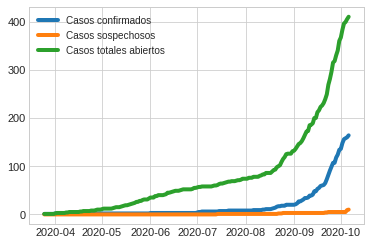

In [ ]:
# graficar
plt.plot(tabla_casos_acumulados.index, tabla_casos_acumulados['Confirmado'], label='Casos confirmados')
plt.plot(tabla_casos_acumulados.index, tabla_casos_acumulados['Sospechoso'], label='Casos sospechosos')
plt.plot(tabla_casos_acumulados.index, tabla_casos_acumulados['Total'], label='Casos totales abiertos')
plt.legend(loc='upper left')


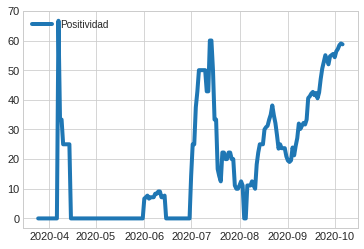

In [ ]:
plt.plot(tabla_casos_por_periodos.index, tabla_casos_por_periodos['Positividad'] * 100, label='Positividad')
plt.legend(loc='upper left')

### Estimar casos no diagnosticados

Estimar qué proporción de los casos sospechosos, que aún no han sido confirmados ni descartados, podrían llegar a ser positivos en base a los valores de positividad calculados para cada día 

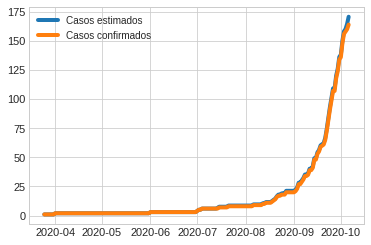

In [ ]:
# estimar casos que serán confirmados eventualmente, según la positividad de los últimos días
tabla_casos_diarios['Estimado'] = tabla_casos_diarios['Confirmado'] + tabla_casos_diarios['Sospechoso'] * tabla_casos_diarios['Positividad']

# corregir datos del último día según hora de corte (17:45hs)
tabla_casos_diarios.loc[tabla_casos_diarios.index[-1], 'Estimado'] *= 24 / 17.75

# calcular acumulados de los casos estimados
tabla_casos_acumulados['Estimado'] = tabla_casos_diarios['Estimado'].cumsum()

# graficar
plt.plot(tabla_casos_acumulados.index, tabla_casos_acumulados['Estimado'], label='Casos estimados')
plt.plot(tabla_casos_acumulados.index, tabla_casos_acumulados['Confirmado'], label='Casos confirmados')
plt.legend(loc='upper left')

In [ ]:
# copiar tabla de datos y agregar columna con nombre 'fecha'
datos = tabla_casos_acumulados.copy()
datos['fecha'] = datos.index
datos = datos.reset_index(drop=True)


## Códigos del modelo

### Función para correr el modelo

In [ ]:
def modelo_SEIR(tabla_datos, fila_inicio=0, fila_fin=-1):

    '''
    Modelo SEIR de paso diario

    Variables de entrada:
        tabla_datos: dataframe con (al menos) las siguientes columnas:
            R0: parámetro R0, un valor para cada fila/día
            Alpha: parámetro Alpha, un valor para cada fila/día
            Gamma: parámetro Gamma, un valor para cada fila/día
            Beta: parámetro Beta (se calcula a partir de R0 y Gamma)
            S: individuos susceptibles, valor para fila inicial
            E: individuos expuestos, valor para fila inicial
            I: individuos infectados, valor para fila inicial
            Ia: individuos infectados acumulados, valor para fila inicial
            R: individuos recuperados/removidos, valor para fila inicial
        fila_inicio: fila correspondiente al día 0 de la simulación (default comienza en fila 0)
        fila_fin: fila correspondiente al último día de la simulación (default hasta la última fila)
    
    Salida: mismo dataframe de entrada con los resultados de individuos S, E, I, R, Ia
    '''

    # hacer una copia de los datos (para no modificar la tabla de datos original)
    datos = tabla_datos.copy()

    # si no se ingresa valor de última fila, contar las filas
    if(fila_fin==-1): fila_fin = len(datos.index) - 1

    for d in range(fila_inicio, fila_fin):

        # leer valores dia actual
        S = datos.loc[d,'S']
        E = datos.loc[d,'E']
        I = datos.loc[d,'I']
        R = datos.loc[d,'R']
        T = S+I+R

        # leer parámetros día actual
        R0 = datos.loc[d,'R0']
        alpha = datos.loc[d,'Alpha']
        gamma = datos.loc[d,'Gamma']
        
        # calcular Beta a partir del R0 y escribirlo en la tabla
        beta = R0 * gamma
        datos.loc[d, 'Beta'] = beta
        
        # calcular valores día siguiente
        S1 = S - beta * S * I/T
        E1 = E + beta * S * I/T - alpha * E
        I1 = I + alpha * E + - gamma * I
        R1 = R + I * gamma
        Ia1 = I1 + R1

        # escribir datos día siguiente
        datos.loc[d+1,'S'] = S1
        datos.loc[d+1,'E'] = E1
        datos.loc[d+1,'I'] = I1
        datos.loc[d+1,'R'] = R1
        datos.loc[d+1,'Ia'] = Ia1

    # resultado
    return datos

### Función para ajustar el modelo

Función que ajusta los parámetros del modelo, minimizando la diferencia entre valores observados y simulados.

In [ ]:
import random
from sklearn.metrics import mean_squared_error
from math import sqrt

def ajustar_modelo(modelo, datos, serie_estimados, serie_observados, inicio_ajuste=0, fin_ajuste=-1, variacion_aleatoria=0.05, maximo_iteraciones=1000, maximo_iteraciones_sin_cambios=150):

    '''
    Función para ajustar parámetros de modelos SEIR de paso diario
    Variables de entrada:
    modelo                          función del modelo a ejecutar
    datos                           tabla de datos con las variables de entrada del modelo
    serie_estimados                 nombre de la serie que contiene los datos estimados por el modelo 
    serie_observados                nombre de la serie que contiene los datos observados
    inicio_ajuste                   fila a partir de la cual se comparan observado y estimado (por defecto la primera fila)
    fin_ajuste                      fila a hasta la cual se comparan observado y estimado (por defecto la última fila)
    variacion_aleatoria             proporción en la que se varían los parámetros en cada iteración
    maximo_iteraciones              cantidad máxima de iteraciones
    maximo_iteraciones_sin_cambios  cantidad de iteraciones sin cambios para considerar ajustado el modelo
    '''

    # hacer una copia de los datos de entrada
    ajuste_preliminar = datos.copy()
    # contar la cantidad de datos observados disponibles
    cantidad_datos = ajuste_preliminar[serie_observados].count()
    ultima_fila = cantidad_datos - 1
    # chequear si se ingresó un valor para la última fila a considerar para el ajuste
    if(fin_ajuste==-1): fin_ajuste=ultima_fila
    # valor inicial rmse
    mejor_rmse = -1
    
    # iterar para mejorar el ajuste, hasta el valor máximo permitido
    for i in range(maximo_iteraciones):

        # correr el modelo para la tabla completa
        ajuste_preliminar = modelo(ajuste_preliminar, 0, ultima_fila)

        # calcular RMSE para el período de ajuste (desde inicio_ajuste hasta fin_ajuste)
        datos_estimados  = ajuste_preliminar.loc[inicio_ajuste:fin_ajuste, serie_estimados]
        datos_observados = ajuste_preliminar.loc[inicio_ajuste:fin_ajuste, serie_observados]
        rmse = sqrt(mean_squared_error(datos_estimados, datos_observados))

        # verificar si el RMSE mejoró (o si es la primera iteración)
        if(rmse<mejor_rmse or i==0): # and minima_diferencia>=0):
            mejor_rmse = rmse
            mejor_ajuste = ajuste_preliminar.copy()
            iteraciones_sin_cambios = 0

        # si no, volver al mejor ajuste anterior
        else:
            ajuste_preliminar = mejor_ajuste.copy()
            iteraciones_sin_cambios = iteraciones_sin_cambios + 1

        # aleatorizar los parámetros para una nueva iteración
        aleatorizar_parametros(ajuste_preliminar, variacion_aleatoria)

        # mostrar progreso
        if(i % 100)==0:
            print(".", end=" ")

        # si ya hubo muchas iteraciones sin que haya cambios, terminar el ajuste
        if(iteraciones_sin_cambios > maximo_iteraciones_sin_cambios): break

    # devolver como resultado el mejor mejor_ajuste obtenido
    return mejor_ajuste


def aleatorizar_parametros(datos, variacion_aleatoria):

    # leer los valores actuales de los parámetros
    R0  = datos.loc[0,'R0']
    S   = datos.loc[0,'S']
    E   = datos.loc[0,'E']
    I   = datos.loc[0,'I']
    Ia  = datos.loc[0,'Ia']
    R   = datos.loc[0,'R']
    T   = S + E + I + R
    
    # aleatorizar el parámetro R0
    multiplicador = random.uniform(1-variacion_aleatoria, 1+variacion_aleatoria)
    R0  = R0  * multiplicador

    # aleatorizar los valores de E e I
    multiplicador = random.uniform(1-variacion_aleatoria, 1+variacion_aleatoria)
    E  = E  * multiplicador
    I  = I  * multiplicador

    # aleatorizar el valor de R
    multiplicador = random.uniform(1-variacion_aleatoria, 1+variacion_aleatoria)
    R = R * multiplicador
    
    # recalcular el resto de las variables iniciales
    Ia = R + I
    S = T - E - I - R

    # actualizar los valores en la planilla de datos
    datos['R0']        = R0
    datos.loc[0, 'S']  = S
    datos.loc[0, 'E']  = E
    datos.loc[0, 'I']  = I
    datos.loc[0, 'Ia'] = Ia
    datos.loc[0, 'R']  = R

## Ajuste de parámetros

### Ajuste para el primer período

In [ ]:
# recortar la tabla de datos y dejar sólo las filas que se van a usar para el ajuste
filas = duracion_lag + duracion_ajuste_1 + 1
datos_ajuste = datos.tail(filas).reset_index(drop=True)

# agregar columnas para los parámetros del modelo, e incluir los valores iniciales en todas las filas
## valores de R0 y Beta a partir de los resultados del ajuste con nexo/sin nexo
datos_ajuste['R0']    = R0
datos_ajuste['Alpha'] = alpha
datos_ajuste['Beta']  = beta
datos_ajuste['Gamma'] = gamma

datos_ajuste['R0']    = 1.5829804653499224  # valor ajuste publicado

# estimar valores iniciales de casos expuestos y activos
casos_primera_semana = datos_ajuste.loc[7, columna_datos] - datos_ajuste.loc[0, columna_datos]
I = max(1, casos_primera_semana) # al menos 1 caso inicial
E = I * gamma / alpha

# tomar valores iniciales de casos acumulados
Ia  = datos_ajuste.loc[0, columna_datos]
R = Ia - I
S = T - E - I - R

# agregar columnas para los compartimientos del modelo y los valores iniciales en la primera fila
datos_ajuste.loc[0, 'S']     = S
datos_ajuste.loc[0, 'E']     = E
datos_ajuste.loc[0, 'I']     = I
datos_ajuste.loc[0, 'Ia']    = Ia
datos_ajuste.loc[0, 'R']     = R

# correr la función de ajuste de parámetros
resultado_ajuste_1 = ajustar_modelo(modelo_SEIR, datos_ajuste, 'Ia', columna_datos, duracion_lag, variacion_aleatoria=0.05)

# mostrar R0 ajustado
print('R0 ajustado:',resultado_ajuste_1.loc[0,'R0'])

. . . . . . . . . . R0 ajustado: 1.5182937568994392


In [ ]:
resultado_ajuste_1

clasificacion_resumen,Confirmado,Descartado,Sospechoso,Total,Estimado,fecha,R0,Alpha,Beta,Gamma,S,E,I,Ia,R
0,34,128,3,165,35.262202,2020-09-08,1.518294,0.333333,0.216899,0.142857,18245.946833,6.764047,15.782776,28.289120,12.506344
1,34,135,3,172,35.262202,2020-09-09,1.518294,0.333333,0.216899,0.142857,18242.528863,7.927335,15.782776,30.543802,14.761027
2,35,135,3,173,36.262202,2020-09-10,1.518294,0.333333,0.216899,0.142857,18239.111315,8.702438,16.170538,33.186247,17.015709
3,39,143,3,185,40.262202,2020-09-11,1.518294,0.333333,0.216899,0.142857,18235.610310,9.302631,16.761274,36.087060,19.325786
4,39,144,3,186,40.262202,2020-09-12,1.518294,0.333333,0.216899,0.142857,18231.981984,9.830079,17.467683,39.187937,21.720253
5,41,145,3,189,42.262202,2020-09-13,1.518294,0.333333,0.216899,0.142857,18228.201386,10.333985,18.248993,42.464630,24.215637
6,48,149,3,200,49.262202,2020-09-14,1.518294,0.333333,0.216899,0.142857,18224.252395,10.838314,19.086656,45.909291,26.822636
7,48,149,3,200,49.262202,2020-09-15,1.518294,0.333333,0.216899,0.142857,18220.122919,11.355018,19.972762,49.522063,29.549301
8,53,156,3,212,54.262202,2020-09-16,1.518294,0.333333,0.216899,0.142857,18215.802587,11.890344,20.904516,53.307069,32.402552
9,55,158,3,216,56.262202,2020-09-17,1.518294,0.333333,0.216899,0.142857,18211.281647,12.447837,21.881605,57.270517,35.388912


### Ajuste para el segundo período

In [ ]:
# recortar la tabla de datos y dejar sólo las filas que se van a usar para el ajuste
filas = duracion_lag + duracion_ajuste_2 + 1
datos_ajuste = resultado_ajuste_1.tail(filas).reset_index(drop=True)

datos_ajuste['R0']    = 1.5839019295856263  # valor ajuste publicado


# correr la función de ajuste de parámetros
resultado_ajuste_2 = ajustar_modelo(modelo_SEIR, datos_ajuste, 'Ia', columna_datos, duracion_lag, variacion_aleatoria=0.05)

# mostrar R0 ajustado
print('R0 ajustado:',resultado_ajuste_2.loc[0,'R0'])

. . . . . R0 ajustado: 1.3046920414450467


### Ajuste para el tercer período

In [ ]:
# recortar la tabla de datos y dejar sólo las filas que se van a usar para el ajuste
filas = duracion_lag + duracion_ajuste_3 + 1
datos_ajuste = resultado_ajuste_2.tail(filas).reset_index(drop=True)

datos_ajuste['R0']    = 1.703779471291687  # valor ajuste publicado


# correr la función de ajuste de parámetros
resultado_ajuste_3 = ajustar_modelo(modelo_SEIR, datos_ajuste, 'Ia', columna_datos, duracion_lag, variacion_aleatoria=0.05)

# mostrar R0 ajustado
print('R0 ajustado:',resultado_ajuste_3.loc[0,'R0'])

. . . R0 ajustado: 1.1162064632588218


### Resultado

Graficar el resultado de los 3 ajustes en comparación con los datos observados

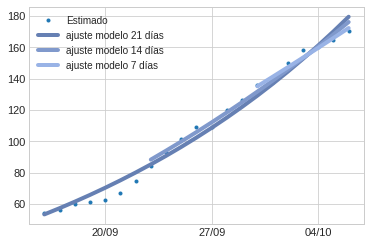

In [ ]:
# casos observados
plt.plot(
    resultado_ajuste_1['fecha'].tail(duracion_ajuste_1),
    resultado_ajuste_1[columna_datos].tail(duracion_ajuste_1), 
    '.', 
    label=columna_datos)

# casos estimados
plt.plot(
    resultado_ajuste_1['fecha'].tail(duracion_ajuste_1),
    resultado_ajuste_1['Ia'].tail(duracion_ajuste_1), 
    '-', 
    color=[0.4,0.5,0.7],
    label='ajuste modelo '+str(duracion_ajuste_1)+' días')
plt.plot(
    resultado_ajuste_2['fecha'].tail(duracion_ajuste_2),
    resultado_ajuste_2['Ia'].tail(duracion_ajuste_2), 
    '-', 
    color=[0.5,0.6,0.8],
    label='ajuste modelo '+str(duracion_ajuste_2)+' días')
plt.plot(
    resultado_ajuste_3['fecha'].tail(duracion_ajuste_3),
    resultado_ajuste_3['Ia'].tail(duracion_ajuste_3), 
    '-', 
    color=[0.6,0.7,0.9],
    label='ajuste modelo '+str(duracion_ajuste_3)+' días')

# ubicación leyeda
plt.legend(loc='upper left')
# formato de fecha
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
# escala semanal
plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator(6))

## Proyecciones

### Proyección simple

In [ ]:
# copiar columnas de datos de la tabla de resultados del ajuste
datos_simulacion_1 = resultado_ajuste_1.tail(duracion_ajuste_1).reset_index(drop=True)
datos_simulacion_2 = resultado_ajuste_2.tail(duracion_ajuste_2).reset_index(drop=True)
datos_simulacion_3 = resultado_ajuste_3.tail(duracion_ajuste_3).reset_index(drop=True)

# función para agregar filas con los días subsiguientes para la proyección del modelo
def armar_tabla_proyeccion(datos_simulacion, duracion_proyeccion):

    for i in range(duracion_proyeccion):
        ultima_fila = datos_simulacion.index.max()
        ultima_fecha = datos_simulacion.loc[ultima_fila, 'fecha']
        datos_simulacion.loc[ultima_fila + 1, 'fecha'] = ultima_fecha + pd.Timedelta(days=1)

    # agregar columnas para los parámetros del modelo, e incluir los valores iniciales en todas las filas
    datos_simulacion['R0']    = datos_simulacion.loc[0, 'R0']
    datos_simulacion['Alpha'] = datos_simulacion.loc[0, 'Alpha']
    datos_simulacion['Beta']  = datos_simulacion.loc[0, 'Beta']
    datos_simulacion['Gamma'] = datos_simulacion.loc[0, 'Gamma']

# llamar a la función para los 3 períodos
armar_tabla_proyeccion(datos_simulacion_1, duracion_proyeccion)
armar_tabla_proyeccion(datos_simulacion_2, duracion_proyeccion)
armar_tabla_proyeccion(datos_simulacion_3, duracion_proyeccion)

# correr las 3 simulaciones
resultado_simulacion_1 = modelo_SEIR(datos_simulacion_1)
resultado_simulacion_2 = modelo_SEIR(datos_simulacion_2)
resultado_simulacion_3 = modelo_SEIR(datos_simulacion_3)


Graficar resultado

(737684.0, 737719.0)

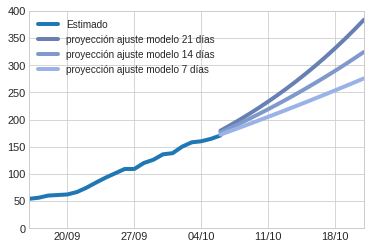

In [ ]:
# casos observados
plt.plot(
    resultado_simulacion_1['fecha'],
    resultado_simulacion_1[columna_datos], 
    '-', 
    label=columna_datos)

# casos estimados
plt.plot(
    resultado_simulacion_1['fecha'].tail(duracion_proyeccion + 1),
    resultado_simulacion_1['Ia'].tail(duracion_proyeccion + 1), 
    '-', 
    color=[0.4,0.5,0.7],
    label='proyección ajuste modelo '+str(duracion_ajuste_1)+' días')
plt.plot(
    resultado_simulacion_2['fecha'].tail(duracion_proyeccion + 1),
    resultado_simulacion_2['Ia'].tail(duracion_proyeccion + 1), 
    '-', 
    color=[0.5,0.6,0.8],
    label='proyección ajuste modelo '+str(duracion_ajuste_2)+' días')
plt.plot(
    resultado_simulacion_3['fecha'].tail(duracion_proyeccion + 1),
    resultado_simulacion_3['Ia'].tail(duracion_proyeccion + 1), 
    '-', 
    color=[0.6,0.7,0.9],
    label='proyección ajuste modelo '+str(duracion_ajuste_3)+' días')

# ubicación leyeda
plt.legend(loc='upper left')
# formato de fecha
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
# escala semanal
plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator(6))
# escala ejes x e y
plt.gca().set_ylim(bottom=0)
plt.gca().set_xlim(left =resultado_simulacion_1['fecha'].iloc[ 0])
plt.gca().set_xlim(right=resultado_simulacion_1['fecha'].iloc[-1])

### Intervalo de variación

Identificar ajuste máximo y mínimo

In [ ]:
# ver los valores de casos estimados finales en cada simulación
ultima_fila = len(resultado_simulacion_1.index) -1
valor_final_simulacion_1 = resultado_simulacion_1.loc[ultima_fila,'Ia']
ultima_fila = len(resultado_simulacion_2.index) -1
valor_final_simulacion_2 = resultado_simulacion_2.loc[ultima_fila,'Ia']
ultima_fila = len(resultado_simulacion_3.index) -1
valor_final_simulacion_3 = resultado_simulacion_3.loc[ultima_fila,'Ia']

# calcular máximo y mínimo
maximo = max([valor_final_simulacion_1, valor_final_simulacion_2, valor_final_simulacion_3])
minimo = min([valor_final_simulacion_1, valor_final_simulacion_2, valor_final_simulacion_3])

# identificar cuál simulación es la que da el valor máximo
if valor_final_simulacion_1 == maximo: maximo_proyeccion = resultado_simulacion_1.copy()
if valor_final_simulacion_2 == maximo: maximo_proyeccion = resultado_simulacion_2.copy()
if valor_final_simulacion_3 == maximo: maximo_proyeccion = resultado_simulacion_3.copy()

# identificar cuál simulación es la que da el valor mínimo
if valor_final_simulacion_1 == minimo: minimo_proyeccion = resultado_simulacion_1.copy()
if valor_final_simulacion_2 == minimo: minimo_proyeccion = resultado_simulacion_2.copy()
if valor_final_simulacion_3 == minimo: minimo_proyeccion = resultado_simulacion_3.copy()

# recortar las tablas para que tengan la misma duración, y que inicien donde terminan los datos observados
maximo_proyeccion = maximo_proyeccion.tail(duracion_proyeccion + 1).reset_index(drop=True)
minimo_proyeccion = minimo_proyeccion.tail(duracion_proyeccion + 1).reset_index(drop=True)


(737684.0, 737719.0)

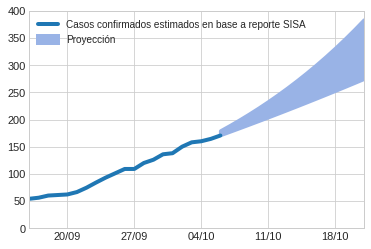

In [ ]:
# casos confirmados
plt.plot(
    resultado_simulacion_1['fecha'],
    resultado_simulacion_1['Estimado'], 
    '-', 
    label='Casos confirmados estimados en base a reporte SISA')

# casos estimados
plt.fill_between(
    maximo_proyeccion['fecha'],
    minimo_proyeccion['Ia'], 
    maximo_proyeccion['Ia'], 
    color=[0.6,0.7,0.9],
    lw=4,
    label='Proyección')

# ubicación leyeda
plt.legend(loc='upper left')
# formato de fecha
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
# escala semanal
plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator(6))
# escala ejes x e y
plt.gca().set_ylim(bottom=0)
plt.gca().set_xlim(left =resultado_simulacion_1['fecha'].iloc[ 0])
plt.gca().set_xlim(right=resultado_simulacion_1['fecha'].iloc[-1])

### Variación de R

Aumentar el R0 para el valor máximo y disminuirlo para el valor mínimo, un % diario.

In [ ]:
filas = len(maximo_proyeccion.index)
variacion_diaria = 0.012

##### Pinamar
# acaba de entrar en fase 3, así que probablemente baje el R
# valor máximo = 1.7 (un poco más alto que el actual)
# valor mínimo = 1.15 (el de mdp en fase 3)

R0 = maximo_proyeccion.loc[0,'R0']
maximo_proyeccion_aumento_R0          = maximo_proyeccion.copy()
maximo_proyeccion_aumento_R0['R0']    = 1.7 #( 1 + pd.Series(range(filas)) * variacion_diaria ) * R0
maximo_proyeccion_aumento_R0          = modelo_SEIR(maximo_proyeccion_aumento_R0)

R0 = minimo_proyeccion.loc[0,'R0']
minimo_proyeccion_disminucion_R0          = minimo_proyeccion.copy()
minimo_proyeccion_disminucion_R0['R0']    = 1.15 #( 1 - pd.Series(range(filas)) * variacion_diaria ) * R0
minimo_proyeccion_disminucion_R0          = modelo_SEIR(minimo_proyeccion_disminucion_R0)


## Resultado

Graficar la proyección final

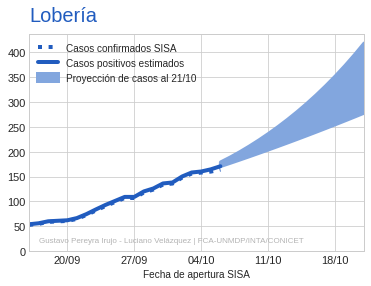

In [ ]:
fecha_min = resultado_simulacion_1['fecha'].iloc[ 0]
fecha_max = resultado_simulacion_1['fecha'].iloc[-1]

# casos estimados variando R0
plt.fill_between(
    maximo_proyeccion['fecha'],
    minimo_proyeccion_disminucion_R0['Ia'], 
    maximo_proyeccion_aumento_R0['Ia'], 
    color=[0.51,0.65,0.87],
    lw=4,
    label='Proyección de casos al ' + fecha_max.strftime('%d/%m'))

# casos confirmados
plt.plot(
    resultado_simulacion_1['fecha'],
    resultado_simulacion_1['Confirmado'], 
    ':', 
    color=[0.13,0.36,0.75],
    label='Casos confirmados SISA')

# casos positivos estimados
plt.plot(
    resultado_simulacion_1['fecha'],
    resultado_simulacion_1['Estimado'], 
    '-', 
    color=[0.13,0.36,0.75],
    label='Casos positivos estimados')

    
# ubicación leyenda
plt.legend(loc='upper left')
# leyenda eje x
plt.xlabel('Fecha de apertura SISA', fontsize=10)
# formato de fecha
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
# escala semanal
plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator(6))
# escala ejes x e y
plt.gca().set_ylim(bottom=0)
plt.gca().set_xlim(left = fecha_min)
plt.gca().set_xlim(right= fecha_max)

# título del gráfico
plt.title(municipio, fontsize=20, horizontalalignment='left', x=0.0, y=1.03, color=[0.13,0.36,0.75])
# autores
plt.text(fecha_min + pd.Timedelta(days=1), maximo*0.05, 'Gustavo Pereyra Irujo - Luciano Velázquez | FCA-UNMDP/INTA/CONICET', fontsize=8, horizontalalignment='left', color=[0.7,0.7,0.7])

# guardar gráfico
municipio_minuscula = municipio.lower().replace(' ', '_')
nombre_archivo = 'proyección_' + municipio_minuscula
archivo_grafico = nombre_archivo + '.png'
plt.savefig(archivo_grafico, bbox_inches = 'tight', pad_inches = 0.1, dpi=150)
# guardar gráfico con fecha
nombre_archivo_fecha = 'proyección_' + fecha_ultima_actualizacion.strftime('%y_%m_%d_') + municipio_minuscula
archivo_grafico = nombre_archivo_fecha + '.png'
plt.savefig(archivo_grafico, bbox_inches = 'tight', pad_inches = 0.1, dpi=150)

In [ ]:
# abrir archivo de texto
archivo_texto = open(nombre_archivo + '.md','w') 

# encabezado
archivo_texto.write(
    '## Proyección de casos para el municipio de ' +
    municipio + 
    '\r\n\r\n' +
    '**'+ultima_actualizacion+'**' +
    '\r\n\r\n---\r\n'
    ) 

# gráfico
archivo_texto.write(
    '![](' + nombre_archivo + '.png?raw=true)' + 
    '\r\n\r\n'
    ) 

# número de casos confirmados, sospechosos, positividad y positivos estimados
casos_confirmados = tabla_casos_acumulados['Confirmado'][-1]
casos_sospechosos = tabla_casos_acumulados['Sospechoso'][-1]
positividad = int(tabla_casos_diarios['Positividad'][-1] * 100)
casos_positivos_estimados = int(tabla_casos_acumulados['Estimado'][-1])

archivo_texto.write(
    'Al día ' + 
    fecha_ultima_actualizacion.strftime('%d/%m') + 
    ' figuran en el SISA ' +
    str(casos_confirmados) + 
    ' casos confirmados y ' +
    str(casos_sospechosos) +
    ' casos sospechosos para el municipio de ' +
    municipio + 
    '. En base a la positividad de ' +
    str(positividad) +
    '% observada en los últimos días, se estiman a la fecha un total de ' + 
    str(casos_positivos_estimados) +
    ' casos positivos.' +
    '\r\n' +
    '\r\n'
    )

# casos proyectados

ultima_fila = len(minimo_proyeccion_disminucion_R0.index) - 1
casos_proyectados_minimo = int(minimo_proyeccion_disminucion_R0.loc[ultima_fila, 'Ia'])
casos_proyectados_maximo = int(maximo_proyeccion_aumento_R0.loc[ultima_fila, 'Ia'])
casos_diarios_minimo = int(round(
    minimo_proyeccion_disminucion_R0.loc[ultima_fila, 'Ia'] - minimo_proyeccion_disminucion_R0.loc[ultima_fila-1, 'Ia']
))
casos_diarios_maximo = int(round(
    maximo_proyeccion_aumento_R0.loc[ultima_fila, 'Ia'] - maximo_proyeccion_aumento_R0.loc[ultima_fila-1, 'Ia']
))

archivo_texto.write(
    'En caso de mantenerse una tendencia similar durante los próximos ' +
    str(duracion_proyeccion) + 
    ' días, se proyecta que al ' + 
    fecha_max.strftime('%d/%m') + 
    ' la cantidad de casos positivos acumulados sería de entre ' +
    str(casos_proyectados_minimo) + 
    ' y ' + 
    str(casos_proyectados_maximo) +
    ', con un promedio de entre ' + 
    str(casos_diarios_minimo) + 
    ' y ' +
    str(casos_diarios_maximo) +
    ' casos por día.' +
    '\r\n' +
    '\r\n'
    )


# valores de R0 observados en los ajustes y proyectados
R0_minimo_ajuste = round(minimo_proyeccion.loc[0, 'R0'], 2)
R0_maximo_ajuste = round(maximo_proyeccion.loc[0, 'R0'], 2)
R0_minimo_final_proyeccion = round(minimo_proyeccion_disminucion_R0['R0'].min(), 2)
R0_maximo_final_proyeccion = round(maximo_proyeccion_aumento_R0['R0'].max(), 2)

archivo_texto.write(
    'El número reproductivo R (promedio de infecciones secundarias a partir de cada caso) observado en los últimos ' + 
    str(duracion_ajuste_1) + 
    ' días fue de entre ' + 
    str(R0_minimo_ajuste) +
    ' y ' +
    str(R0_maximo_ajuste) +
    ', mientras que la proyección asume que podría llegar a aumentar hasta ' +
    str(R0_maximo_final_proyeccion) +
    ' o disminuir hasta ' +
    str(R0_minimo_final_proyeccion) +
    '. ' +
    '\r\n'
    )

# pie de página
archivo_texto.write(
    '\r\n---\r\n\r\n' +
    'Elaboración: Gustavo Pereyra Irujo / Luciano Velázquez - FCA-UNMDP / INTA / CONICET' +
    '\r\n\r\n'
    ) 

# cerrar archivo de texto
archivo_texto.close() 
